# Get embeddings from dataset

https://github.com/openai/openai-cookbook/blob/main/examples/Zero-shot_classification_with_embeddings.ipynb

In [79]:
! pip install -qU tiktoken

In [80]:
import pandas as pd
import tiktoken

In [81]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [82]:
# load & inspect dataset
input_datapath = "/content/fine_food_reviews_1k.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


In [83]:
# subsample to 1k most recent reviews and remove samples that are too long
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)

encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)
len(df)
df.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52
297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178


In [84]:
! pip install -qU openai

In [85]:
from openai import OpenAI
import numpy as np
import pandas as pd
from typing import List, Optional

client = OpenAI(api_key="...removed for security reasons...", max_retries=5)

def get_embedding(text: str, model="text-embedding-3-small", **kwargs) -> List[float]:
    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")

    response = client.embeddings.create(input=[text], model=model, **kwargs)

    return response.data[0].embedding

# This may take a few minutes
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, model=embedding_model))
df.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.0359942801296711, -0.02117965929210186, -0...."
297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.07047566026449203, -0.031760234385728836, ..."


In [86]:
# Convert 5-star rating to binary sentiment
df = df[df.Score != 3]
df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})
df.head(2)

<ipython-input-86-cb7febb0040f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})


,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,sentiment
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.0359942801296711, -0.02117965929210186, -0....",positive
297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.07047566026449203, -0.031760234385728836, ...",positive


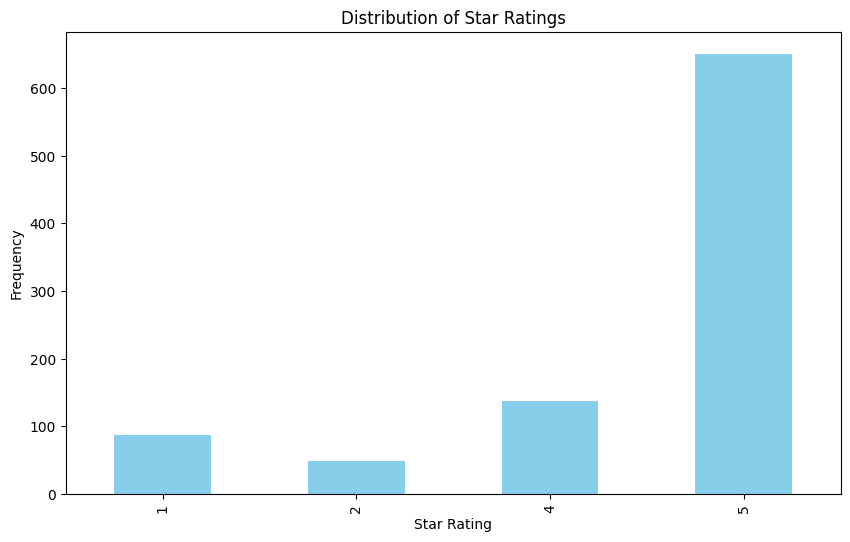

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df['Score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Star Ratings')
plt.show()

In [88]:
EMBEDDING_MODEL = "text-embedding-3-small"

In [89]:
def cosine_similarity(a, b):
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [90]:
from sklearn.metrics import classification_report, PrecisionRecallDisplay

def evaluate_embeddings_approach(
    labels = ['negative', 'positive'],
    model = EMBEDDING_MODEL,
):
    label_embeddings = [get_embedding(label, model=model) for label in labels]
    print(len(label_embeddings[0]))

    def label_score(review_embedding, label_embeddings):
        return cosine_similarity(review_embedding, label_embeddings[1]) - cosine_similarity(review_embedding, label_embeddings[0])

    # Apply to test set
    probas = df["embedding"].apply(lambda x: label_score(x, label_embeddings))
    preds = probas.apply(lambda x: 'positive' if x > 0 else 'negative')

    # Evaluate and report
    report = classification_report(df.sentiment, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
    _ = display.ax_.set_title("2-class Precision-Recall curve")

1536
              precision    recall  f1-score   support

    negative       0.76      0.96      0.85       136
    positive       0.99      0.95      0.97       789

    accuracy                           0.95       925
   macro avg       0.88      0.96      0.91       925
weighted avg       0.96      0.95      0.95       925



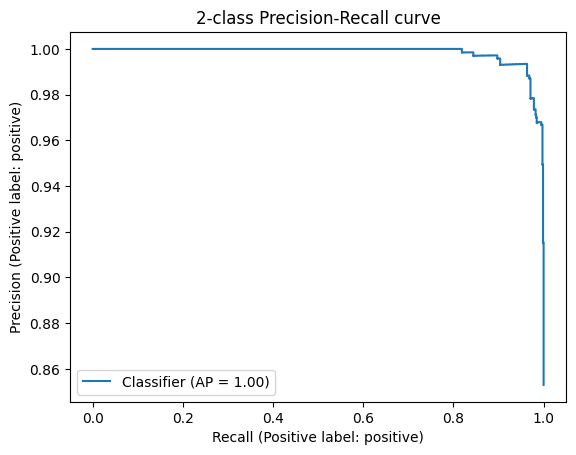

In [91]:
# Run the evaluation
evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.'], model=EMBEDDING_MODEL)

In [92]:
"""
plot the distribution of cosine similarities of all embeddings from the original DataFrame against the embeddings of the labels
"""

labels = ['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.']
label_embeddings = [get_embedding(label, model=EMBEDDING_MODEL) for label in labels]

# Compute cosine similarities
df['cosine_similarity_positive'] = df['embedding'].apply(lambda x: cosine_similarity(x, label_embeddings[1]))
df['cosine_similarity_negative'] = df['embedding'].apply(lambda x: cosine_similarity(x, label_embeddings[0]))

# Create 2D plot
plt.figure(figsize=(400, 100))

# Scatter plot for the overall sentiment
plt.scatter(df.index, df['cosine_similarity_positive'] - df['cosine_similarity_negative'], label='Overall Sentiment', alpha=0.6, color='blue')

# Plot +1 and -1 lines based on 'Score' in the original dataframe
for index, row in df.iterrows():
    if row['Score'] == 4:
        plt.vlines(index, ymin=0, ymax=0.5, linestyle='-', color='limegreen')
    elif row['Score'] == 5:
        plt.vlines(index, ymin=0, ymax=1.0, linestyle='--', color='green')
    elif row['Score'] == 2:
        plt.vlines(index, ymin=-0.5, ymax=0, linestyle='--', color='maroon')
    else:
        plt.vlines(index, ymin=-1.0, ymax=0, linestyle='--', color='red')


# Add a line at y=0
plt.axhline(y=0, color='black', linestyle='--')

# Manually set x-axis ticks
x_ticks = np.arange(0, len(df), 10)  # Set ticks at regular intervals
plt.xticks(x_ticks)

# Adding labels and title
plt.xlabel('Review Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarities of Review Embeddings with Sentiment Label Embeddings')
plt.legend()

# Show plot
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [93]:
df.head()

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,sentiment,cosine_similarity_positive,cosine_similarity_negative
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.0359942801296711, -0.02117965929210186, -0....",positive,0.259907,0.184936
297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.07047566026449203, -0.031760234385728836, ...",positive,0.269843,0.284460
296,B008JKTTUA,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[0.05685221776366234, -0.005375450011342764, 0...",negative,0.256392,0.277577
295,B000LKTTTW,A14MQ40CCU8B13,5,Best tomato soup,I have a hard time finding packaged food of an...,Title: Best tomato soup; Content: I have a har...,111,"[-0.011264046654105186, -0.049711164087057114,...",positive,0.231478,0.200360
294,B001D09KAM,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[0.05685221776366234, -0.005375450011342764, 0...",negative,0.256392,0.277577


In [94]:
# Define the conditions for false negatives and false positives
false_negatives_condition = (df['cosine_similarity_positive'] - df['cosine_similarity_negative'] < 0) & (df['sentiment'] == 'positive')
false_positives_condition = (df['cosine_similarity_positive'] - df['cosine_similarity_negative'] > 0) & (df['sentiment'] == 'negative')

# Create new dataframes for false negatives and false positives
false_negatives_df = df[false_negatives_condition]
false_positives_df = df[false_positives_condition]


In [95]:
print(len(false_negatives_df))
print(len(false_positives_df))

42
5


In [96]:
selected_columns = ['Score', 'combined', 'sentiment', 'cosine_similarity_positive', 'cosine_similarity_negative']

In [97]:
false_positives_df_selected = false_positives_df[selected_columns]
false_positives_df_selected.head()

,Score,combined,sentiment,cosine_similarity_positive,cosine_similarity_negative
289,1,Title: Cute; Content: For some reason I though...,negative,0.298958,0.264921
224,2,"Title: Paw Flapper Fun, But Too Easy; Content:...",negative,0.216349,0.195577
345,1,Title: Okay if you like cinnamon candy.; Conte...,negative,0.180843,0.141223
335,1,Title: WE LOVE POP CHIPS!; Content: We love PO...,negative,0.232581,0.211385
172,2,"Title: Paw Flapper Fun, But Too Easy; Content:...",negative,0.216349,0.195577


In [101]:
false_negatives_df_selected = false_negatives_df[selected_columns]
false_negatives_df_selected.head()

,Score,combined,sentiment,cosine_similarity_positive,cosine_similarity_negative
297,4,"Title: Good, but not Wolfgang Puck good; Conte...",positive,0.269843,0.284460
278,5,"Title: Great coffee, not bitter.; Content: I'm...",positive,0.240900,0.248411
318,4,Title: yummy cookies!; Content: We've ordered ...,positive,0.208597,0.253642
242,4,Title: yummy cookies!; Content: We've ordered ...,positive,0.208597,0.253642
233,4,Title: Good quality grinder; Content: I had be...,positive,0.221388,0.224694


In [102]:
# Trying differnt labels

sentiment_labels = ['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.']
sentiment_labels_embeddings = [get_embedding(label, model=EMBEDDING_MODEL) for label in sentiment_labels]

false_positives_df_with_sentiment_labels = false_positives_df_selected
false_positives_df_with_sentiment_labels['cosine_similarity_positive'] = false_positives_df['embedding'].apply(lambda x: cosine_similarity(x, sentiment_labels_embeddings[1]))
false_positives_df_with_sentiment_labels['cosine_similarity_negative'] = false_positives_df['embedding'].apply(lambda x: cosine_similarity(x, sentiment_labels_embeddings[0]))
false_positives_df_with_sentiment_labels.head()

<ipython-input-102-2673e7d3e69d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives_df_with_sentiment_labels['cosine_similarity_positive'] = false_positives_df['embedding'].apply(lambda x: cosine_similarity(x, sentiment_labels_embeddings[1]))
<ipython-input-102-2673e7d3e69d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives_df_with_sentiment_labels['cosine_similarity_negative'] = false_positives_df['embedding'].apply(lambda x: cosine_similarity(x, sentiment_labels_embeddings[0])

,Score,combined,sentiment,cosine_similarity_positive,cosine_similarity_negative
289,1,Title: Cute; Content: For some reason I though...,negative,0.298958,0.264935
224,2,"Title: Paw Flapper Fun, But Too Easy; Content:...",negative,0.216349,0.195558
345,1,Title: Okay if you like cinnamon candy.; Conte...,negative,0.180843,0.141209
335,1,Title: WE LOVE POP CHIPS!; Content: We love PO...,negative,0.232581,0.211384
172,2,"Title: Paw Flapper Fun, But Too Easy; Content:...",negative,0.216349,0.195558


In [103]:
false_negatives_df_with_sentiment_labels = false_negatives_df_selected
false_negatives_df_with_sentiment_labels['cosine_similarity_positive'] = false_negatives_df['embedding'].apply(lambda x: cosine_similarity(x, sentiment_labels_embeddings[1]))
false_negatives_df_with_sentiment_labels['cosine_similarity_negative'] = false_negatives_df['embedding'].apply(lambda x: cosine_similarity(x, sentiment_labels_embeddings[0]))
false_negatives_df_with_sentiment_labels.head()

<ipython-input-103-3e4a1f9d1521>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives_df_with_sentiment_labels['cosine_similarity_positive'] = false_negatives_df['embedding'].apply(lambda x: cosine_similarity(x, sentiment_labels_embeddings[1]))
<ipython-input-103-3e4a1f9d1521>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives_df_with_sentiment_labels['cosine_similarity_negative'] = false_negatives_df['embedding'].apply(lambda x: cosine_similarity(x, sentiment_labels_embeddings[0])

,Score,combined,sentiment,cosine_similarity_positive,cosine_similarity_negative
297,4,"Title: Good, but not Wolfgang Puck good; Conte...",positive,0.269843,0.284467
278,5,"Title: Great coffee, not bitter.; Content: I'm...",positive,0.240900,0.248402
318,4,Title: yummy cookies!; Content: We've ordered ...,positive,0.208597,0.253621
242,4,Title: yummy cookies!; Content: We've ordered ...,positive,0.208597,0.253621
233,4,Title: Good quality grinder; Content: I had be...,positive,0.221388,0.224713


In [134]:
recommendation_labels = [
    "A review on Amazon which suggests this product to be a bad purchase or over-priced; or is disappointed with its quantity or quality; or complaints about an unpleasant experience due to poor service from vendor or Amazon such as poor package quality, lack of support or delay; or recommends not buying from Amazon.",
    "A review on Amazon which recommends this product as a good purchase worth its price; or it favorably discusses its quality or quantity or vendor's service; or expresses product love by repeat ordering e.g. every month."
]
recommendation_labels_embeddings = [get_embedding(label, model=EMBEDDING_MODEL) for label in recommendation_labels]

false_positives_df_with_recommendation_labels = false_positives_df_selected
false_positives_df_with_recommendation_labels['cosine_similarity_positive'] = false_positives_df['embedding'].apply(lambda x: cosine_similarity(x, recommendation_labels_embeddings[1]))
false_positives_df_with_recommendation_labels['cosine_similarity_negative'] = false_positives_df['embedding'].apply(lambda x: cosine_similarity(x, recommendation_labels_embeddings[0]))
false_positives_df_with_recommendation_labels.head()

<ipython-input-134-351647788e7e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives_df_with_recommendation_labels['cosine_similarity_positive'] = false_positives_df['embedding'].apply(lambda x: cosine_similarity(x, recommendation_labels_embeddings[1]))
<ipython-input-134-351647788e7e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives_df_with_recommendation_labels['cosine_similarity_negative'] = false_positives_df['embedding'].apply(lambda x: cosine_similarity(x, recommendation_l

,Score,combined,sentiment,cosine_similarity_positive,cosine_similarity_negative
289,1,Title: Cute; Content: For some reason I though...,negative,0.312281,0.281283
224,2,"Title: Paw Flapper Fun, But Too Easy; Content:...",negative,0.196197,0.212715
345,1,Title: Okay if you like cinnamon candy.; Conte...,negative,0.198347,0.148171
335,1,Title: WE LOVE POP CHIPS!; Content: We love PO...,negative,0.290098,0.289242
172,2,"Title: Paw Flapper Fun, But Too Easy; Content:...",negative,0.196197,0.212715


In [135]:
false_negatives_df_with_recommendation_labels = false_negatives_df_selected
false_negatives_df_with_recommendation_labels['cosine_similarity_positive'] = false_negatives_df['embedding'].apply(lambda x: cosine_similarity(x, recommendation_labels_embeddings[1]))
false_negatives_df_with_recommendation_labels['cosine_similarity_negative'] = false_negatives_df['embedding'].apply(lambda x: cosine_similarity(x, recommendation_labels_embeddings[0]))
false_negatives_df_with_recommendation_labels.head()

<ipython-input-135-06965a6bd11a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives_df_with_recommendation_labels['cosine_similarity_positive'] = false_negatives_df['embedding'].apply(lambda x: cosine_similarity(x, recommendation_labels_embeddings[1]))
<ipython-input-135-06965a6bd11a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives_df_with_recommendation_labels['cosine_similarity_negative'] = false_negatives_df['embedding'].apply(lambda x: cosine_similarity(x, recommendation_l

,Score,combined,sentiment,cosine_similarity_positive,cosine_similarity_negative
297,4,"Title: Good, but not Wolfgang Puck good; Conte...",positive,0.313892,0.349168
278,5,"Title: Great coffee, not bitter.; Content: I'm...",positive,0.244339,0.250036
318,4,Title: yummy cookies!; Content: We've ordered ...,positive,0.321476,0.261750
242,4,Title: yummy cookies!; Content: We've ordered ...,positive,0.321476,0.261750
233,4,Title: Good quality grinder; Content: I had be...,positive,0.346773,0.312336


1536
              precision    recall  f1-score   support

    negative       0.81      0.88      0.85       136
    positive       0.98      0.96      0.97       789

    accuracy                           0.95       925
   macro avg       0.90      0.92      0.91       925
weighted avg       0.95      0.95      0.95       925



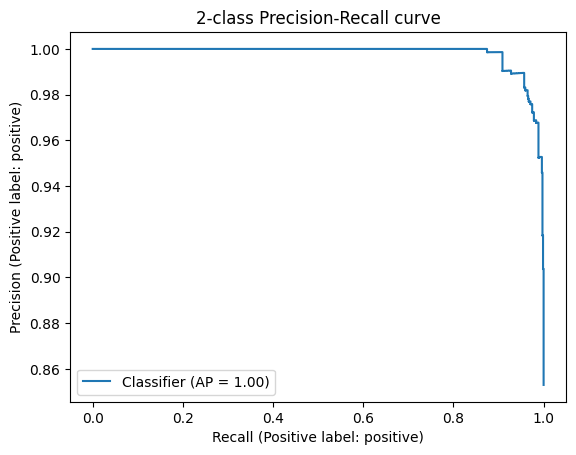

In [136]:
# Run the evaluation
evaluate_embeddings_approach(labels=recommendation_labels, model=EMBEDDING_MODEL)

Comparing the two sets of results, we can see some differences in precision, recall, and F1-score for both classes (negative and positive), as well as for the overall metrics like accuracy, macro average, and weighted average.

Let's break it down:

1. **Precision**: Precision tells us how many of the predicted positive cases are actually positive. In both cases, the precision for the positive class is very high, above 0.95, indicating that the model is good at correctly identifying positive cases. However, for the negative class, precision has increased from 0.76 to 0.81, meaning that the second approach is better at correctly identifying negative cases.

2. **Recall**: Recall tells us how many of the actual positive cases were identified correctly. Here, both approaches have similar recall for the positive class (around 0.95-0.96), indicating that they are both good at capturing positive cases. For the negative class, recall has slightly decreased from 0.96 to 0.88 in the second approach, meaning that it's capturing fewer of the actual negative cases.

3. **F1-score**: F1-score is the harmonic mean of precision and recall, giving us a balance between the two. In both cases, F1-scores are quite high for both classes, indicating a good balance between precision and recall.

4. **Accuracy**: Accuracy tells us the overall correctness of the model. In both cases, the accuracy remains the same at 0.95, meaning that both approaches are equally good at classifying the data overall.

Considering these factors, the second approach seems to have slightly improved in terms of precision for the negative class while slightly decreasing in recall for the negative class. However, since the changes are not substantial and the accuracy remains the same, we could say that the performance between the two approaches is relatively similar.